# Loan Default Prediction:Exploratory Data Analysis

**Authors:**  
- Dave Karanja
- Jedidiah Wambui

**Project Repository:**  
GitHub: https://github.com/karanja-dave/NgaoLabs/tree/dave/Loan_default_prediction

NB: Ensure all dataset files are stored in a data folder in unzipped format. This prevents file path errors and ensures smooth, consistent data loading during analysis.

**Date:**  
15 February 2026  

---

## Project Objective

This notebook presents the exploratory data analysis conducted prior to model development.  
The purpose of the analysis is to:

- Understand data structure and feature distributions  
- Detect missing values and anomalies  
- Assess categorical imbalance  
- Examine relationships with the target variable  
- Inform preprocessing and model selection decisions  

## Objectives

### General Objective
- Prepare and analyze customer demographics, performance, and loan history to predict loan default risk.

### Specific Objectives
1. **Data Cleaning:** Handle missing values, convert dates, and create basic features like age and relative risk.  
2. **Exploratory Data Analysis (EDA):** Explore distributions, identify outliers, and visualize patterns in the data.  
3. **Feature Engineering:** Generate features such as previous loan defaults, default rates, and risk ratios.  
4. **Encoding & Dataset Preparation:** Encode categorical variables and structure datasets for modeling.  
5. **Data Integration:** Merge demographics, performance, and previous loan datasets into a single consolidated dataset for analysis and modeling.


In [1]:
###import libraries for
#EDA
import pandas as pd 
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#data preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Data Preparation

In these section, all three datasets: demographics, performance, and previous loans, were carefully loaded and examined for missing values and inconsistencies. Columns with more than 50% missing data were dropped, while important categorical fields like employment status were imputed with the most frequent values. Date fields, such as birthdates and loan approval or repayment dates, were converted to datetime format, allowing the creation of new features including age, loan approval periods, and repayment delays. Additionally, relative risk was calculated to capture the ratio of current to average historical loan amounts per customer. Unnecessary columns, such as temporary calculation fields and original date columns after feature engineering, were removed to ensure a clean, consistent dataset ready for exploratory analysis, visualization, and subsequent modeling.

In [2]:
## wrangle func 
#demographics 
def wrangle_demo(path):
    # load data 
    df=pd.read_csv(path)

    # drop features with high null count >0.5
    mask_na=df.isna().mean()>0.5    
    df.drop(columns=df.columns[mask_na],inplace=True)

    # impute missing values in employment status with mode employment status 
    mode_value = df['employment_status_clients'].mode()[0]
    df['employment_status_clients'] = df['employment_status_clients'].fillna(mode_value)

    # convert `datatype` to date
    df['birthdate'] = pd.to_datetime(df['birthdate'])
    # get everyone's age
    df['age']=(pd.Timestamp.today()-df['birthdate']).dt.days//365
    # drop `datatype` col 
    df.drop(columns='birthdate',inplace=True)

    return df

#performance data 
def wrangle_perf(path):
    # load data 
    df=pd.read_csv(path)
    # drop features with high null count
    mask_na=df.isna().mean()>0.5    
    df.drop(columns=df.columns[mask_na],inplace=True)
    # # convert `approvedate`&`creationdate` to date type
    # df['approveddate'] = pd.to_datetime(df['approveddate'])
    # df['creationdate'] = pd.to_datetime(df['creationdate'])

    # for now drop the time date cols 
    df.drop(columns=['approveddate','creationdate'],inplace=True)

    # relative risk
    # ompute average historical loan amount per customer
    df['avg_loan_amt'] = df.groupby('customerid')['loanamount'].transform('mean')
    # compute relative risk : loan to avergae loan ration/
    df['relative_risk'] = df['loanamount'] / df['avg_loan_amt']
    # drop `avg_loan_amt` col 
    df.drop(columns=['avg_loan_amt'], inplace=True)

    return df

##previous loans data 
def wrangle_prev_loans(path):
    # load data 
    df=pd.read_csv(path)
    #deal with high null counts
    mask_na=df.isna().mean()>0.5
    df.drop(columns=df.columns[mask_na],inplace=True)

    # select only date cols 
    mask_date=df.select_dtypes(include='object').drop(columns='customerid').columns
    # convert dates to date data type 
    for col in mask_date:
        df[col] = pd.to_datetime(df[col], errors='coerce')
    
    # loan approval period in hours: most loans are approved within a day
    df['approval_period'] = (df['approveddate'] - df['creationdate']).dt.total_seconds() / 3600

    # load default
    # loan repayment perido (days) : first loan
    df['first_delay'] = (df['firstrepaiddate'] - df['firstduedate']).dt.days 
    # subsequent loan delays (days)
    df['loan_delays'] = (df['closeddate'] - df['approveddate']).dt.days - df['termdays']
    # defaulted loans : Im using loans beyond dues date are defaulted 
    df['prev_loan_default'] = ((df['first_delay'] > 0) | (df['loan_delays'] > 0)).astype(int)
    #drop date cols, `first_delay` and `loan_delays`
    date_cols=df.select_dtypes(include='datetime').columns
    df.drop(columns=list(date_cols) + ['first_delay','loan_delays'],inplace=True)

    # relative risk
    # ompute average historical loan amount per customer
    df['avg_loan_amt'] = df.groupby('customerid')['loanamount'].transform('mean')
    # compute relative risk : loan to avergae loan ration/
    df['relative_risk'] = df['loanamount'] / df['avg_loan_amt']
    # drop `avg_loan_amt` col 
    df.drop(columns=['avg_loan_amt'], inplace=True)

    return df

The data wrangling functions for the datasets were developed based on insights from the initial EDA. The EDA guided decisions such as which columns to drop due to high missing values, which categorical fields required imputation, how to handle date columns, and which new features should be created to enhance the dataset for analysis and modeling.

In [8]:
### load data sets
##demographics data
demo_train=wrangle_demo('../data/traindemographics.csv')
demo_test=wrangle_demo('../data/testdemographics.csv')
# performance data 
perf_train=wrangle_perf('../data/trainperf.csv')
perf_test=wrangle_perf('../data/testperf.csv')

# previous loans data
prev_loans_train=wrangle_prev_loans("../data/trainprevloans.csv") 
prev_loans_test=wrangle_prev_loans('../data/testprevloans.csv')


C:\Users\davek\AppData\Local\Temp\ipykernel_18936\1338915590.py:57: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  mask_date=df.select_dtypes(include='object').drop(columns='customerid').columns
C:\Users\davek\AppData\Local\Temp\ipykernel_18936\1338915590.py:57: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.

The datasets were loaded using the wrangling functions to ensure consistent formatting, feature creation and that the data was prepared for effective use in analysis and model building 

# Explanatory Data Analysis (EDA)
EDA was performed to understand the structure, distribution, and quality of the datasets. This included examining numerical and categorical variables, detecting missing values, identifying outliers, and visualizing patterns. The insights gained from EDA guided feature engineering, data cleaning decisions, and informed the preparation of the datasets for modeling.

## Demographics


In [9]:
### EDA 
##demographics 
demo_train.info()
demo_test.info()
demo_train.head()
demo_test.head()

# check for missing values
demo_train.isna().mean()>0.5
demo_train.isna().sum()
demo_test.isna().mean()>0.5
demo_test.isna().sum()

# dealing with cardinality
cate_var = demo_train.select_dtypes(include="object").drop(columns='customerid')
print("Cardinality count for categorical variables:\n")
cate_var.nunique()
print('\n `birthdate` will be used to get ages of bank clients. \n Transform it to date instead \n')
print("\n `customerid` is the primary key to be used to merge the 3 data-sets \n")
print("\n No high nor low cardinality is observed \n")
# detailed info on categorical variables
for col in cate_var:
    print(f"{col}: {demo_train[col].nunique()} unique values")
    print(demo_train[col].value_counts(dropna=False))
    print("-"*50)


<class 'pandas.DataFrame'>
RangeIndex: 4346 entries, 0 to 4345
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerid                 4346 non-null   str    
 1   bank_account_type          4346 non-null   str    
 2   longitude_gps              4346 non-null   float64
 3   latitude_gps               4346 non-null   float64
 4   bank_name_clients          4346 non-null   str    
 5   employment_status_clients  4346 non-null   str    
 6   age                        4346 non-null   int64  
dtypes: float64(2), int64(1), str(4)
memory usage: 237.8 KB
<class 'pandas.DataFrame'>
RangeIndex: 1487 entries, 0 to 1486
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerid                 1487 non-null   str    
 1   bank_account_type          1487 non-null   str    
 2   longitude_gps    

C:\Users\davek\AppData\Local\Temp\ipykernel_18936\2409927844.py:15: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  cate_var = demo_train.select_dtypes(include="object").drop(columns='customerid')


After applying the data wrangling functions, the demographics datasets were cleaned and ready for analysis. Prior to cleaning, several columns contained missing values and inconsistent formats. The wrangling functions successfully handled these issues by imputing missing employment statuses, converting birthdate to age, and dropping columns with excessive missing data. After wrangling EDA showed that both datasets contained 7 columns with no missing values. Categorical analysis revealed that `bank_account_type` had 3 unique values, `bank_name_clients` had 18, and `employment_status_clients `had 6. The distributions indicated that most clients held a savings account, most banked with GT Bank, and the majority were permanently employed. There were no extreme cardinality issues, confirming that the datasets were well prepared for encoding and modeling. These results demonstrate that the wrangling functions effectively cleaned and structured the data as intended.

### Visualization: Demographics 

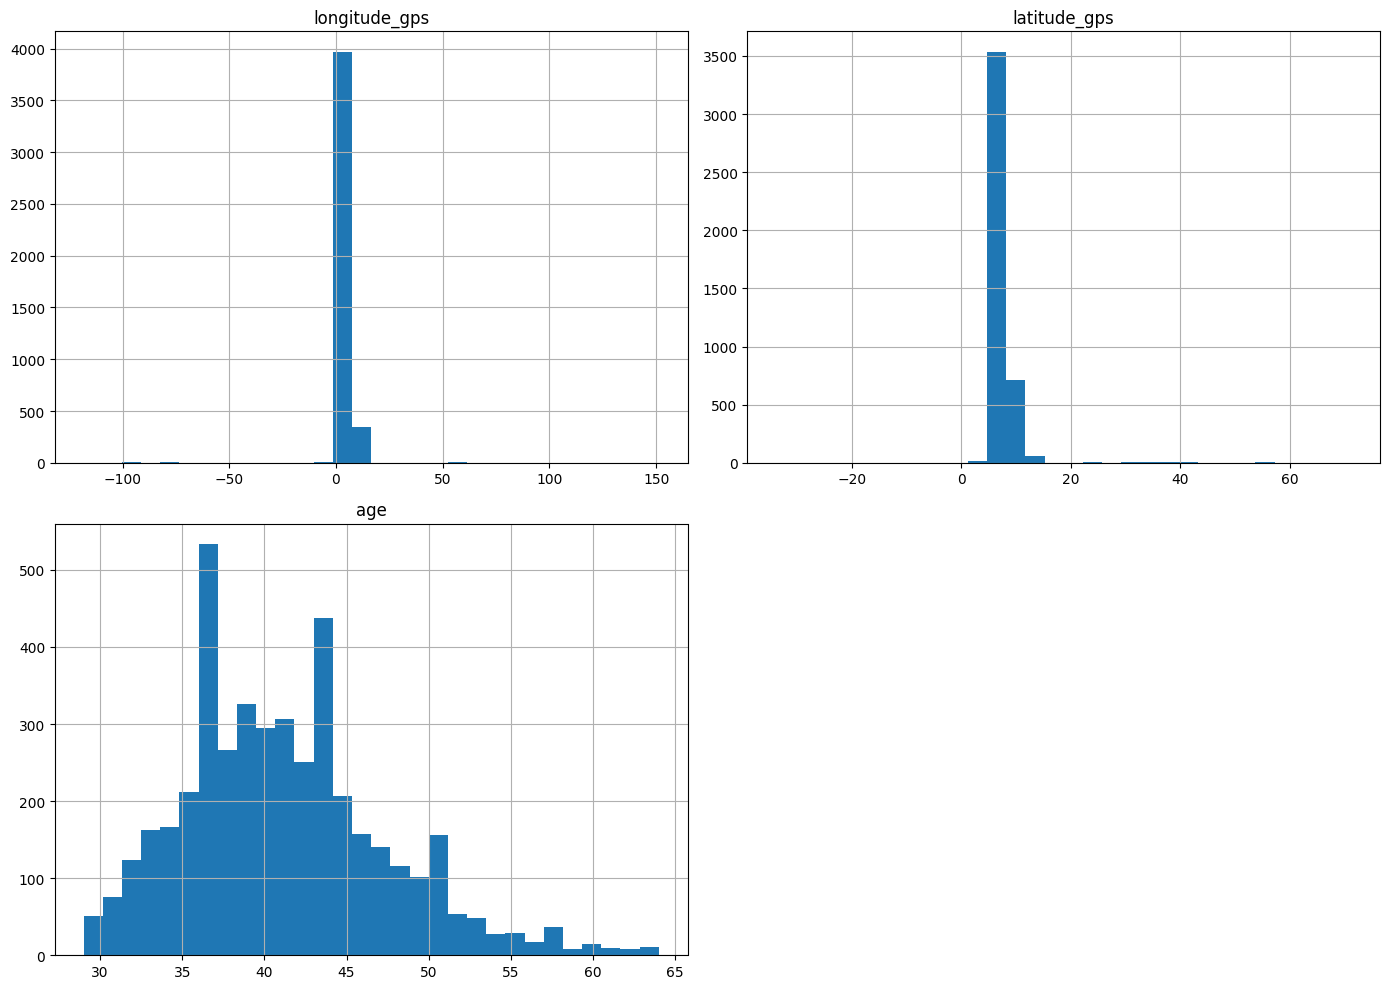

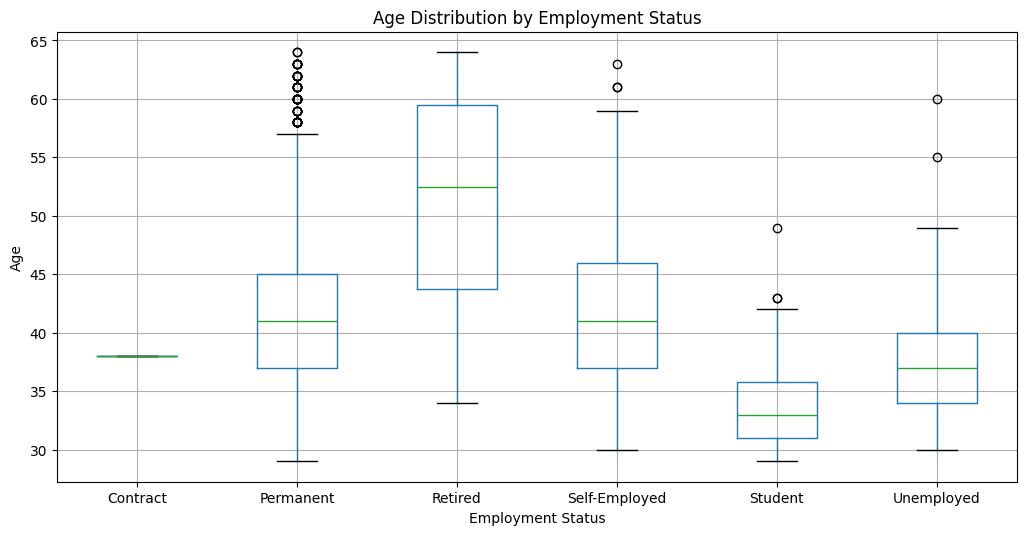

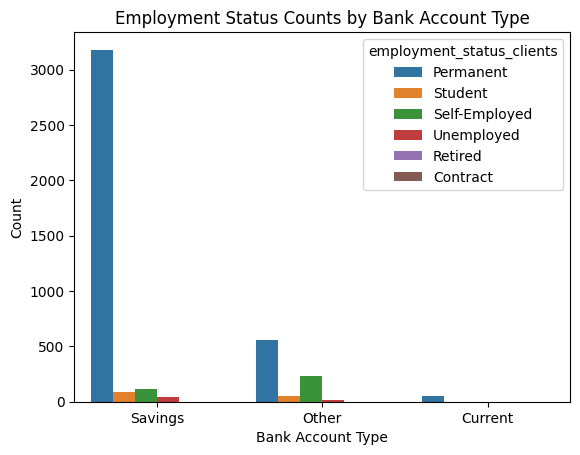

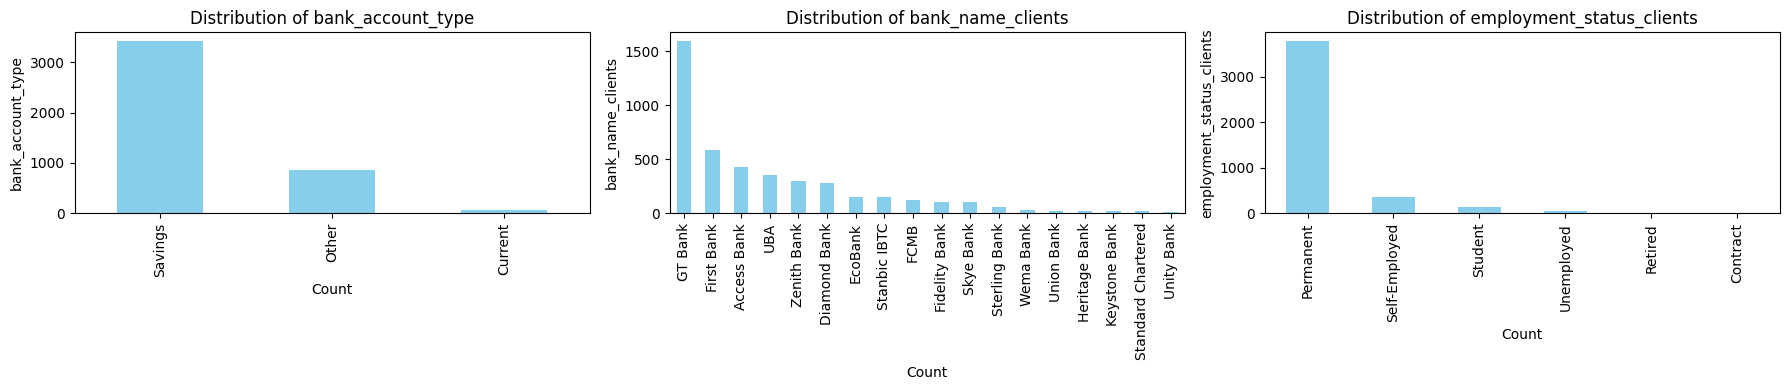

In [10]:
##visulaization
# histogram : Distribution of numerical cols 
num_cols = demo_train.select_dtypes(include=["int64","float64"]).columns

demo_train[num_cols].hist(bins=30, figsize=(14,10))
plt.tight_layout()
plt.show()

#age distribution with employment status
demo_train.boxplot(column='age', by='employment_status_clients', figsize=(12,6))
plt.title('Age Distribution by Employment Status')
plt.suptitle('')  
plt.ylabel('Age')
plt.xlabel('Employment Status')
plt.show()

# employment dist with bank type 
sns.countplot(data=demo_train, x='bank_account_type', hue='employment_status_clients')
plt.title('Employment Status Counts by Bank Account Type')
plt.xlabel('Bank Account Type')
plt.ylabel('Count')
plt.show()

# barchart
# func to plot barchart 
def plot_barh(df, col, ax):
    df[col].value_counts().plot(
        kind='bar',
        ax=ax,
        color='skyblue'
    )
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel("Count")
    ax.set_ylabel(col)

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

plot_barh(demo_train, 'bank_account_type', axes[0])
plot_barh(demo_train, 'bank_name_clients', axes[1])
plot_barh(demo_train, 'employment_status_clients', axes[2])

plt.tight_layout()
plt.show()


Visualization was used to better understand the distribution and relationships of numerical and categorical variables in the cleaned demographics dataset. Histograms showed the overall distribution of numerical features, including age and GPS coordinates, highlighting central tendencies and spread. A boxplot of age by employment status revealed that permanent employees tended to be older, while students and contract workers were younger. Count plots examined the relationship between employment status and bank account type, showing that most permanent employees held savings accounts across different banks. Additional bar charts illustrated the distribution of key categorical variables: bank_account_type, bank_name_clients, and employment_status_clients. These visualizations confirmed patterns observed during EDA, helped identify group differences, and provided a clear basis for feature encoding and modeling.

### Encoding: Demographics
Encoding is done to convert categorical data into a numerical format that machine learning models can understand. Most ML algorithms likelogistic regression, linear regression, neural networks, e.t.c, can't work directly with text or string labels. One-hot encoding is used here because the categorical variables in your demographics dataset (`bank_account_type`, `bank_name_clients`, and `employment_status_clients`) are nominal. This means the categories have no inherent order or ranking.

In [11]:
# categorical encoding
# init ohe
ohe = OneHotEncoder(drop='first', sparse_output=False)  # drop='first' avoids dummy variable trap for linear models

# select categorical columns for OHE
ohe_cols = ['bank_account_type', 'employment_status_clients', 'bank_name_clients']

# fit & transform train data
demo_train_ohe = pd.DataFrame(
    ohe.fit_transform(demo_train[ohe_cols]),
    columns=ohe.get_feature_names_out(ohe_cols),
    index=demo_train.index
)

# transform test data using the same encoder
demo_test_ohe = pd.DataFrame(
    ohe.transform(demo_test[ohe_cols]),
    columns=ohe.get_feature_names_out(ohe_cols),
    index=demo_test.index
)

# drop original categorical columns and concatenate OHE columns
demo_train = pd.concat([demo_train.drop(columns=ohe_cols), demo_train_ohe], axis=1)
demo_test = pd.concat([demo_test.drop(columns=ohe_cols), demo_test_ohe], axis=1)

demo_train.info()
demo_test.info()

<class 'pandas.DataFrame'>
RangeIndex: 4346 entries, 0 to 4345
Data columns (total 28 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   customerid                               4346 non-null   str    
 1   longitude_gps                            4346 non-null   float64
 2   latitude_gps                             4346 non-null   float64
 3   age                                      4346 non-null   int64  
 4   bank_account_type_Other                  4346 non-null   float64
 5   bank_account_type_Savings                4346 non-null   float64
 6   employment_status_clients_Permanent      4346 non-null   float64
 7   employment_status_clients_Retired        4346 non-null   float64
 8   employment_status_clients_Self-Employed  4346 non-null   float64
 9   employment_status_clients_Student        4346 non-null   float64
 10  employment_status_clients_Unemployed     4346 non-null   fl

The selected categorical columns (`bank_account_type`, `employment_status_clients`, and `bank_name_clients`) were one-hot encoded for both train and test sets. The encoding was applied to the training data using fit_transform, and the same encoder was used to transform the test data, ensuring consistency. After encoding, the original categorical columns were dropped, and the newly created binary columns were concatenated with the datasets. This process ensured that all categorical information was preserved in a numeric format suitable for model training.

### Dealing with outliers: Demographics 
Outliers are extreme values that deviate significantly from the majority of the data. They can distort statistical analyses, bias model estimates, and reduce predictive accuracy. Detecting and handling outliers ensures that the dataset reflects realistic, reliable values, making the models more robust and the analysis more meaningful.

In [12]:
# outliers in age : age shld be b2n [18,80]
demo_train[~demo_train['age'].between(18, 80)]
demo_test[~demo_test['age'].between(18, 80)]
print("\n No unrealistic ages")

# outliers in location 
demo_train[
    ~(
        demo_train['longitude_gps'].between(2, 15) &
        demo_train['latitude_gps'].between(4.0, 14)
    )
]



 No unrealistic ages


,customerid,longitude_gps,latitude_gps,age,bank_account_type_Other,bank_account_type_Savings,employment_status_clients_Permanent,employment_status_clients_Retired,employment_status_clients_Self-Employed,employment_status_clients_Student,...,bank_name_clients_Keystone Bank,bank_name_clients_Skye Bank,bank_name_clients_Stanbic IBTC,bank_name_clients_Standard Chartered,bank_name_clients_Sterling Bank,bank_name_clients_UBA,bank_name_clients_Union Bank,bank_name_clients_Unity Bank,bank_name_clients_Wema Bank,bank_name_clients_Zenith Bank
56,8a8588c9548a33b201548b3cdb0f0c53,-117.822509,33.883619,36,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
91,8a858f73594ab1ea01595e72de584bca,-7.239446,54.998841,39,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
397,8a85897353d85af80153db21edaa0bf8,-84.378662,33.577121,46,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
497,8a858fa25bd92c20015be258fc2f3a87,-95.737058,29.784622,34,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
673,8a858e64590ae20001591534eb0647ec,-73.985657,40.748516,35,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
691,8a858e7d595026f80159636aa36f487b,-3.560050,54.593071,37,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
752,8a858f1f586c8fc8015870ffe8e17424,-0.065909,5.648275,32,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
856,8a858f2d5853901a01586650578e325f,56.342638,25.351997,39,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1014,8a858e245c214660015c2ad957886351,-3.977151,5.299440,39,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1285,8a858eda552adcc201553deed53a2493,100.077895,71.228069,39,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Age was checked to ensure it fell within a realistic range of 18 to 80 years. Both the training and test datasets contained only valid ages, so no unrealistic values were present. Geographic coordinates (`longitude_gps` and `latitude_gps`) were also examined against Nigeria’s approximate ranges (longitude 2–15, latitude 4–14). While a few coordinates fell outside these ranges, they were retained because they could represent Nigerians living abroad who still took loans. These checks confirmed that the datasets were largely clean and that extreme or invalid values were either nonexistent or justifiable, supporting reliable analysis and modeling.

## Performance

In [13]:
perf_train.info()
perf_test.info()

# check for missing values 
perf_train.isna().mean()>0.5
perf_test.isna().mean()>0.5
perf_train.isna().sum()
perf_test.isna().sum()

# dealing with cardinality 
perf_train.select_dtypes(include='object')['good_bad_flag'].value_counts()


<class 'pandas.DataFrame'>
RangeIndex: 4368 entries, 0 to 4367
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   customerid     4368 non-null   str    
 1   systemloanid   4368 non-null   int64  
 2   loannumber     4368 non-null   int64  
 3   loanamount     4368 non-null   float64
 4   totaldue       4368 non-null   float64
 5   termdays       4368 non-null   int64  
 6   good_bad_flag  4368 non-null   str    
 7   relative_risk  4368 non-null   float64
dtypes: float64(3), int64(3), str(2)
memory usage: 273.1 KB
<class 'pandas.DataFrame'>
RangeIndex: 1450 entries, 0 to 1449
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   customerid     1450 non-null   str    
 1   systemloanid   1450 non-null   int64  
 2   loannumber     1450 non-null   int64  
 3   loanamount     1450 non-null   int64  
 4   totaldue       1450 non-null   float64
 5

C:\Users\davek\AppData\Local\Temp\ipykernel_18936\2318116276.py:11: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  perf_train.select_dtypes(include='object')['good_bad_flag'].value_counts()


good_bad_flag
Good    3416
Bad      952
Name: count, dtype: int64

After applying the performance data wrangling function, both performance datasets were cleaned and structured for analysis. All columns were complete with no missing values, confirming that the wrangling function successfully handled nulls and unnecessary features. The date columns (`approveddate` and `creationdate`) were considered obsolete for the analysis (the test data had parsing issues, likely due to entry errors, making it impossible to convrt to date types. To maintain consistency, the same columns were also dropped in the training data even though it had no parsing issues). The target variable, `good_bad_flag`, is categorical with two classes representing loan repayment status and was retained in the training set since it is absent in the test set. Its low cardinality makes it suitable for classification tasks. Overall, the wrangling function effectively prepared the performance data, ensuring it is clean, consistent, and ready for feature integration and predictive modeling.

### Visualization: Performance

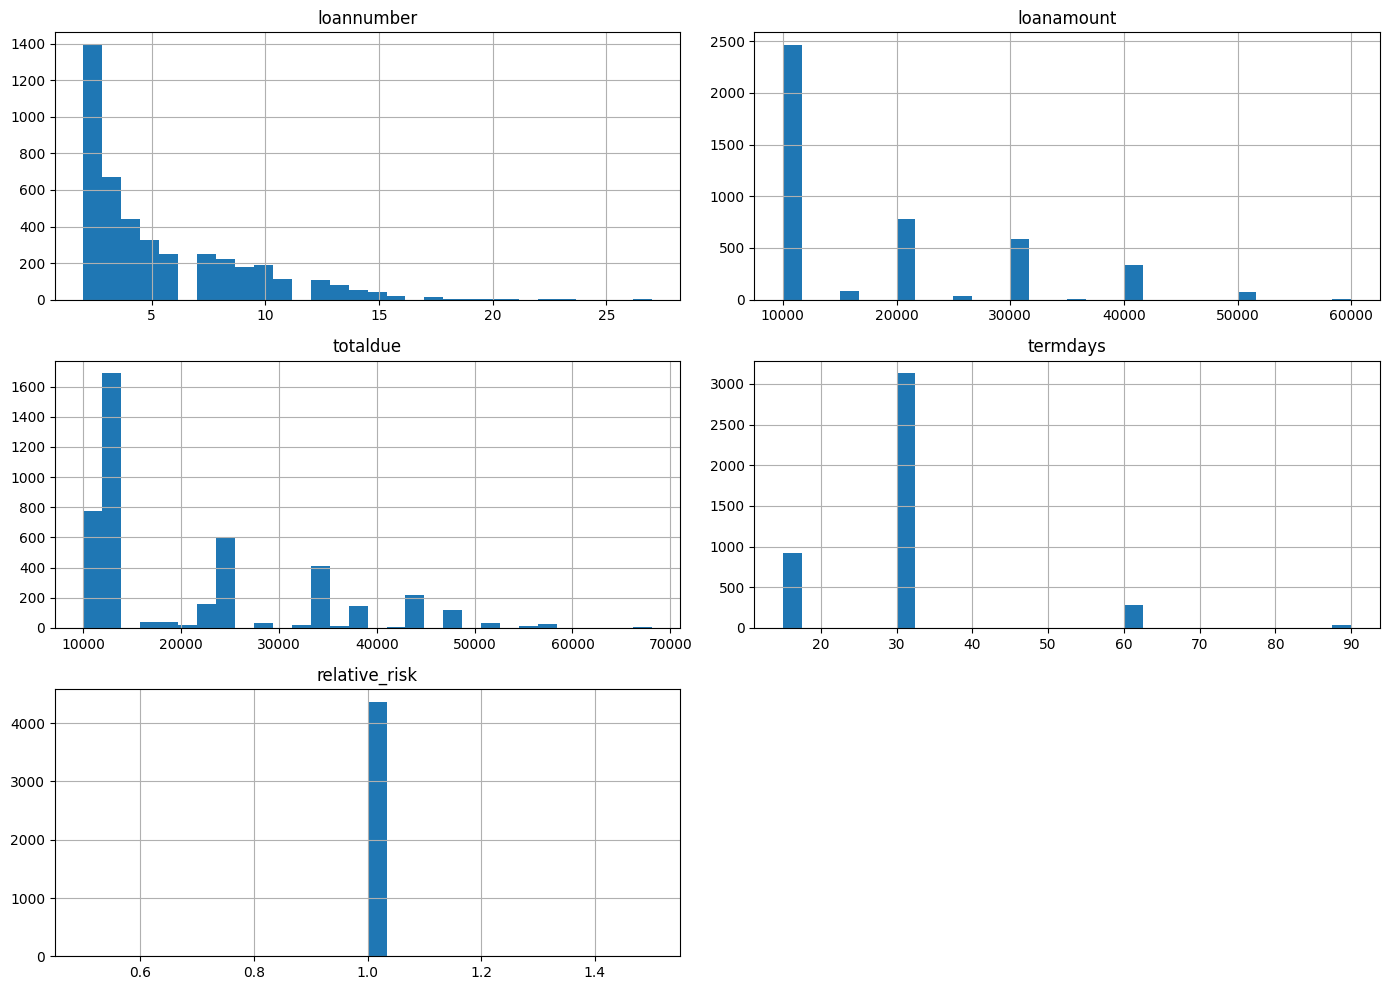

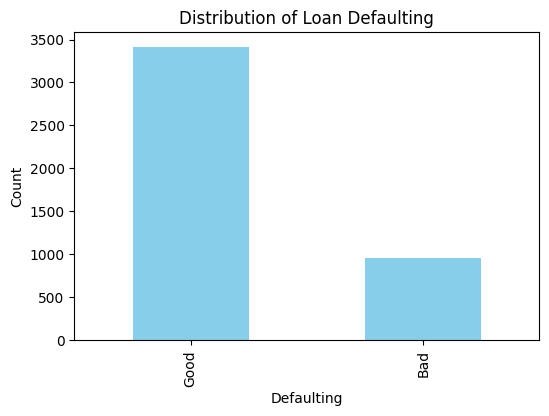

In [14]:

#hist:dist of numerical variables
num_cols = perf_train.select_dtypes(include=["int64","float64"]).drop(columns='systemloanid').columns

perf_train[num_cols].hist(bins=30, figsize=(14,10))
plt.tight_layout()
plt.show()

# barchart: dist for categorical var
(perf_train['good_bad_flag'].value_counts().
    plot( kind='bar',figsize=(6,4),color='skyblue', title=f'Distribution of Loan Defaulting'))

plt.xlabel("Defaulting")
plt.ylabel('Count') 
plt.show()

Visualizations were used to examine the distribution of numerical and categorical features in the cleaned performance dataset. Histograms of numerical variables, showed the spread, central tendencies, and potential skewness, helping identify patterns in customer loan behavior. A bar chart of the target variable `good_bad_flag` revealed that out of 4,368 loans in the training set, 3,416 were classified as “Good” and 952 as “Bad,” indicating a moderate imbalance. These visualizations provided a clear understanding of feature distributions, confirmed that the data was properly cleaned, and highlighted patterns that could be important for predictive modeling. These visualizations provided a clear understanding of feature distributions, confirmed that the data was properly cleaned, and highlighted patterns that could be important for predictive modeling.

### label encoding: perfomance data 
Label encoding is used to convert categorical variables into numeric values that machine learning models can process. It is applied to ordinal variables, where the categories have a natural order or represent classes. The target variable `good_bad_flag` will be label-encoded so that “Good” and “Bad” could be represented as 0 and 1 for classification modeling.

In [15]:
#label encoding
y_train=perf_train['good_bad_flag']
# target encoding
le_target=LabelEncoder() 
y_train=le_target.fit_transform(y_train)
np.unique(y_train)

array([0, 1])

## Previous Loans data 

In [16]:
prev_loans_train.info()
prev_loans_test.info()

# check for null counts 
prev_loans_train.isna().mean()>0.5
prev_loans_test.isna().mean()>0.5

# check if dates are of type date : no output as dates are dropped
prev_loans_train.select_dtypes(include='datetime').head()
prev_loans_test.select_dtypes(include='datetime').head()

#aggregate previous loan defaults per customer
customer_features = prev_loans_train.groupby('customerid').agg(
    num_bad_loans=('prev_loan_default', 'sum'),          # total previous defaults
    default_rate_prev=('prev_loan_default', 'mean'),    # fraction of loans defaulted
    recent_default_flag=('prev_loan_default', 'last')   # default status of most recent loan
).reset_index()

<class 'pandas.DataFrame'>
RangeIndex: 18183 entries, 0 to 18182
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customerid         18183 non-null  str    
 1   systemloanid       18183 non-null  int64  
 2   loannumber         18183 non-null  int64  
 3   loanamount         18183 non-null  float64
 4   totaldue           18183 non-null  float64
 5   termdays           18183 non-null  int64  
 6   approval_period    18183 non-null  float64
 7   prev_loan_default  18183 non-null  int64  
 8   relative_risk      18183 non-null  float64
dtypes: float64(4), int64(4), str(1)
memory usage: 1.2 MB
<class 'pandas.DataFrame'>
RangeIndex: 5907 entries, 0 to 5906
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customerid         5907 non-null   str    
 1   systemloanid       5907 non-null   int64  
 2   loannumber         5907 n

After applying the wrangling function, the previous loans datasets were cleaned and structured for analysis. Columns with excessive missing values were removed, and date columns were converted to datetime format to calculate useful features, such as `approval_period`, `first_delay`, and `loan_delays`. Using these, a new binary feature `prev_loan_default` was created to flag whether a loan was defaulted. After these computations, all original date columns, along with intermediate calculation columns (`first_delay`, `loan_delays`), were dropped to simplify the dataset. Additionally, a `relative_risk` feature was computed by comparing each loan amount to the customer’s historical average, capturing risk behavior. Finally, the dataset was aggregated per customer, producing three key features: `num_bad_loans` (total defaults), `default_rate_prev` (fraction of loans defaulted), and `recent_default_flag` (status of the most recent loan). These steps ensured that the previous loans data was clean, consistent, and summarized effectively for predictive modeling.

### visulaization : Previos loans 


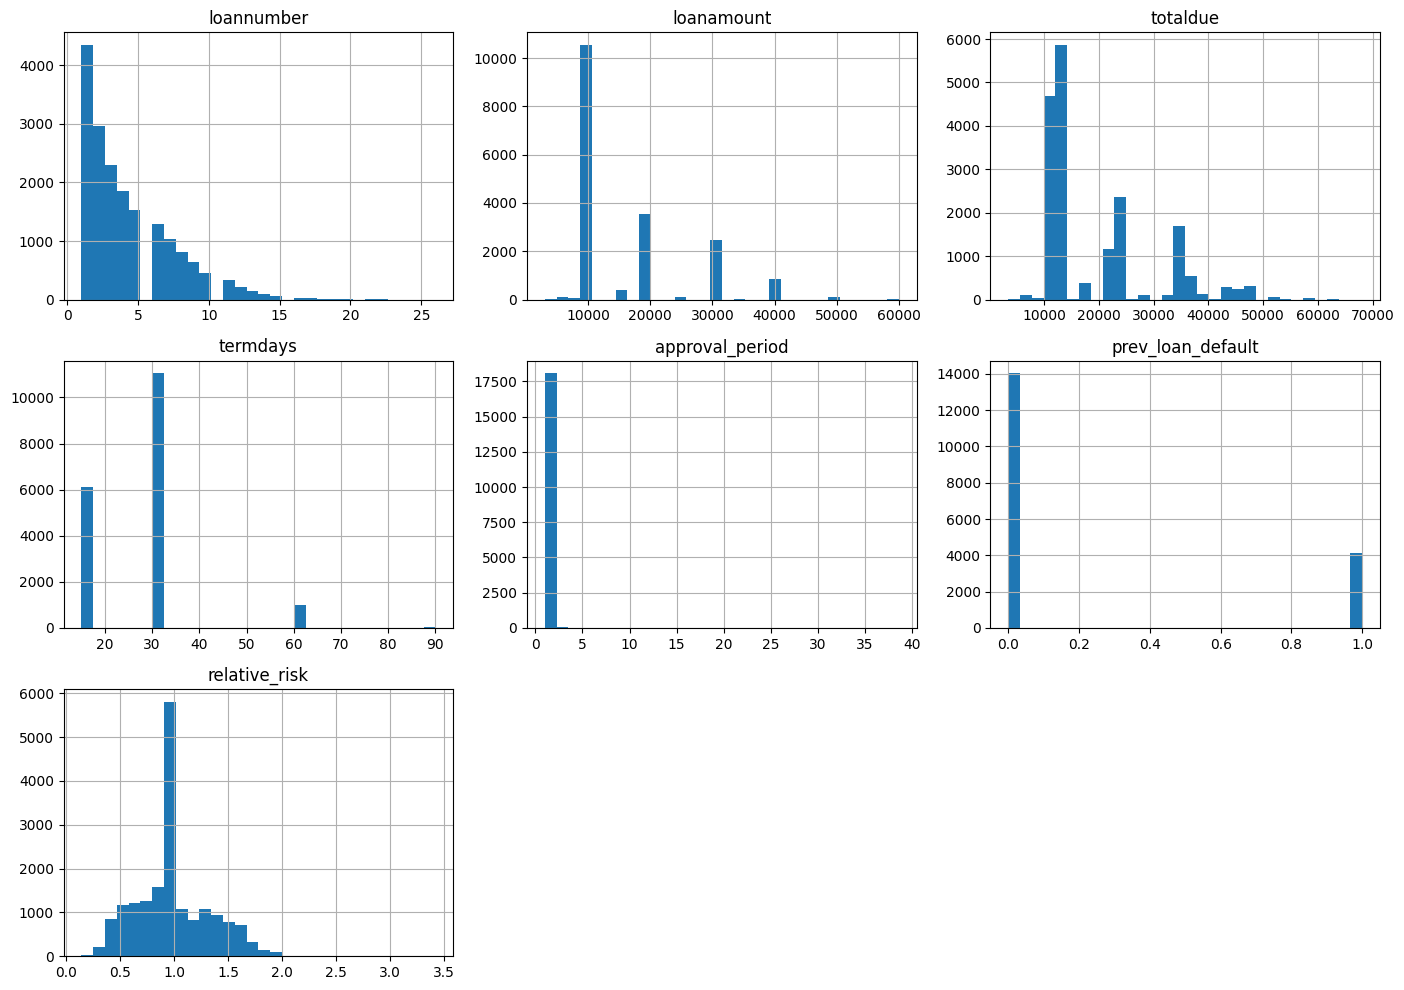

In [17]:
# hist :dist of all numerical vars 
num_cols = prev_loans_train.select_dtypes(include=["int64","float64"]).drop(columns='systemloanid').columns

prev_loans_train[num_cols].hist(bins=30, figsize=(14,10))
plt.tight_layout()
plt.show()

Most features in the previous loans dataset were numerical, so their distributions were examined using histograms. This allowed observation of the spread, central tendencies, and potential skewness in features such as num_bad_loans, default_rate_prev, and recent_default_flag. The histograms provided a clear view of customer loan behaviors and highlighted patterns that could inform modeling decisions, such as identifying customers with higher historical default rates.